In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm


# Data analysis

In [65]:
df = pd.read_csv('./datasets/steps.csv')
df = df.loc[df['tangram nr' ] ==4]
df = df[['sid','tangram nr','step']]
participants = df.groupby(['sid','tangram nr']).max()['step'].to_numpy()
participants

array([13., 24.,  7.,  7.,  8., 15.,  8., 23.,  7., 48.,  7.,  7.,  8.,
        9., 10., 18.,  9., 10.,  7., 23.,  7.,  9.,  9., 11., 18., 19.,
       12., 11.,  7., 17., 33.])

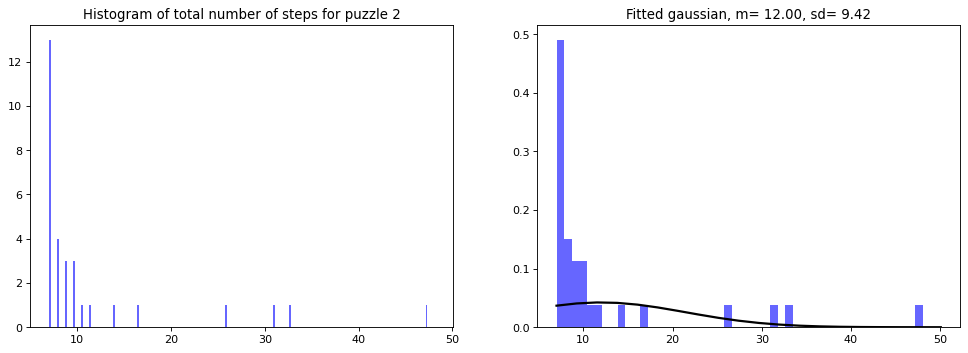

In [14]:
df = pd.read_csv('./datasets/steps.csv')
df = df.loc[df['tangram nr' ] ==2]
df = df[['sid','tangram nr','step']]
participants = df.groupby(['sid','tangram nr']).max()['step'].to_numpy()

data = participants
plt.figure(figsize=(15, 5), dpi=80)
ax = plt.subplot(121)
ax.set_title('Histogram of total number of steps for puzzle 2')
# H, bins = np.histogram(data,bins=int(np.max(data)))

# ax.bar(bins[:-1],H,width=0.5)
ax.hist(data, bins=int(np.max(participants)), alpha=0.6, width=0.2, color='b')
ax = plt.subplot(122)
mu, std = norm.fit(data)

ax.hist(data, bins=int(np.max(participants)), density=True,stacked=True, alpha=0.6, color='b')
xmin, xmax = (7,plt.xlim()[1])
x = np.linspace(xmin, xmax, 20)
p = norm.pdf(x, mu, std)
ax.set_title('Fitted gaussian, m= {:.2f}, sd= {:.2f}'.format(mu,std))
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [66]:
pno=participants[participants< mu + 3*std]
norm.fit(pno)

(12.433333333333334, 6.509906980048862)

In [201]:
df = pd.read_csv('./datasets/steps.csv')
df = df.loc[df['tangram nr' ] ==2]
df = df[['sid','tangram nr','step']]
participants = df.groupby(['sid','tangram nr']).max()['step'].to_numpy()
print('participants pre-trim')
print(f'mean: {participants.mean()}, std: {participants.std()}, max: {participants.max()}')
participants = participants[participants<participants.mean()+3*participants.std()]
print('participants')
print(f'mean: {participants.mean()}, std: {participants.std()}, max: {participants.max()}')
print(np.count_nonzero(participants == 7))

participants pre-trim
mean: 12.0, std: 9.42200581343416, max: 48.0
participants
mean: 10.8, std: 6.862458257310812, max: 33.0
13


# General stats
Avg number of steps, std...

In [303]:
mat = pd.read_csv("results/heatmap_4_no_pm.csv",header=None).to_numpy()

In [304]:
solved_at = (mat==0).argmax(axis=1)
solved_at[solved_at==0] = mat.shape[1] 

In [305]:
print(f'mean: {solved_at.mean()}, std: {solved_at.std()}, perfect: {np.count_nonzero(solved_at == 7)}')

mean: 12.0, std: 6.957010852370434, perfect: 16


# Heatmaps

In [298]:
heatmap = np.zeros((5,10))
for i in range(5):
    p = i+1
    for m in range(10):
        heatmap[i,m] = np.count_nonzero(mat[:,m] == p)


In [299]:
heatmap = heatmap/heatmap.sum(axis=0,keepdims=1)

In [300]:
data = np.loadtxt('datasets/heatmap4.txt')

In [301]:
rmse =np.sqrt(np.mean((heatmap-data)**2, axis=0))
print(rmse)

[0.20676947 0.12649111 0.13620562 0.10939665 0.23249391 0.2723238
 0.16683654 0.39532827 0.38819382 0.45404012]


In [302]:
np.mean(rmse)

0.2488079308167343

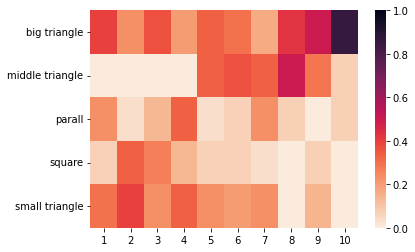

In [294]:
cmap = sns.cm.rocket_r
y_axis_labels = ['small triangle','square','parall','middle triangle','big triangle']
x_axis_labels = [1,2,3,4,5,6,7,8,9,10]
fig, ax = plt.subplots()
sns.heatmap(heatmap,ax=ax,yticklabels=y_axis_labels,xticklabels=x_axis_labels,cmap=cmap,vmin=0, vmax=1)
ax.invert_yaxis()
plt.show()


# Sequence evaluation

Tangram 2

In [268]:
tgn = 4
users = pd.read_csv('datasets/train_states.csv')
users = users.loc[users['tangram nr'] ==tgn]
model = pd.read_csv(f'results/model_states_evolution_{tgn}_no_data.csv')

## Method1: step-by-step matching

For each run, the model gets its score by comparing the position at each step with user data at step +-1, scoring 1 point if there is any match

In [269]:
limits = {2:int(10.8+6.9),4:int(12.4+6.5)}
offset = [1,2,3,3,3]
score = 0
max_score = 0
errors= 0
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    if len(run_steps) < 17:
        errors+=1
        continue
    for step in range(3,limits.get(tgn)):
        
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step'].isin(list(range(step-offset[step//4], step + offset[step//4]+1)))][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res= users_at_step.loc[
                (users_at_step['small triangle'] == state['small triangle']) &
                (users_at_step['middle triangle'] == state['middle triangle']) &
                (users_at_step['big triangle'] == state['big triangle']) &
                (users_at_step['square'] == state['square']) &
                (users_at_step['parallelogram'] == state['parallelogram'])
            ]
            if not res.empty:
                score+=1
print(score)
print(max_score)
print(score/max_score)
print(errors)

81
179
0.45251396648044695
0


In [221]:
score = 0
max_score = 0
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,12):
        state = run_steps.iloc[step][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step'].isin([step-1,step,step+1])][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res= users_at_step.loc[
                (users_at_step['small triangle'] == state['small triangle']) &
                (users_at_step['middle triangle'] == state['middle triangle']) &
                (users_at_step['big triangle'] == state['big triangle']) &
                (users_at_step['square'] == state['square']) &
                (users_at_step['parallelogram'] == state['parallelogram'])
            ]
            if not res.empty:
                score+=1
print(score)
print(max_score)
print(score/max_score)

IndexError: single positional indexer is out-of-bounds

## Method1: rms

In [166]:
def state_diff(model,user):
    diff = 0
    for c in ['small triangle','middle triangle','big triangle','square','parallelogram']:
        if user[c] != model[c]:
            diff +=1
    return diff



errors = 10*np.ones((len(model.run.unique()),13))
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,16):
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res = users_at_step.apply(lambda x: state_diff(state,x),axis=1)
            rmse = np.sqrt(np.mean((res)**2))
            errors[run,step-3] = rmse
#             res= users_at_step.loc[
#                 (users_at_step['small triangle'] == state['small triangle']) &
#                 (users_at_step['middle triangle'] == state['middle triangle']) &
#                 (users_at_step['big triangle'] == state['big triangle']) &
#                 (users_at_step['square'] == state['square']) &
#                 (users_at_step['parallelogram'] == state['parallelogram'])
#             ]


errors.min(axis=0)

array([2.29492193, 2.40138849, 2.20605228, 2.18326972, 2.34520788,
       2.20605228, 2.30940108, 2.10554823, 1.97484177, 2.25831796,
       2.20605228, 2.04939015, 2.01659779])

In [160]:
def state_diff(model,user):
    diff = 0
    for c in ['small triangle','middle triangle','big triangle','square','parallelogram']:
        if user[c] != model[c]:
            diff +=1
    return diff


score = 0
max_score = 0
errors = 10*np.ones((len(model.run.unique()),13))
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,16):
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res = users_at_step.apply(lambda x: state_diff(state,x),axis=1)
            errors[run,step-3] = min(res)
            if not res.empty:
                score+=1
print(score)
print(max_score)
 
print(score/max_score)

errors

305
305
1.0


array([[ 0.,  1.,  0.,  1.,  0.,  0., 10., 10., 10., 10., 10., 10., 10.],
       [ 1.,  1.,  1.,  2.,  2.,  2.,  1.,  2.,  1.,  0.,  0., 10., 10.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0., 10.],
       [ 1.,  2.,  0.,  1.,  0.,  0., 10., 10., 10., 10., 10., 10., 10.],
       [ 0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  1.],
       [ 1.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,  1.,  0., 10., 10.],
       [ 2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  0., 10., 10., 10.],
       [ 1.,  0.,  1.,  2.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.],
       [ 1.,  1.,  1.,  0.,  1.,  1., 

In [74]:
step=3
users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
run_steps=  model.loc[model.run == 1]
state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]



## Method2: phase-by-phase matching

For each run, the results is matched at step 4, 8 and 12, getting incremental points if such sequence also appears in participants data, some margin or error is accepted

In [72]:
score=0
same_seq= 0
for run in model.run.unique():

    run_steps = model.loc[model.run == run]
    
    #step 4
    step=4
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-1,step+2))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=1
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]
    
    #step 8
    step = 8
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-2,step+3))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=2
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]
    
#     step 8
    step = 12
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-3,step+4))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=3
    same_seq +=1
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]

print(score)
print(same_seq)

16
2
